# Model Quest

Or in other words: "How to Train, Finetune, and Export a Model for MXNet Model Server"

MXNet Model Server (MMS) is a great way for you to experiment with different models and provide a simple route for you and others to run inference or predictions. You can prototype ideas and applications that use a deep learning model as a core capability or a great "AI" feature.

One of the easiest routes for exporting a model is to use a model zoo. We'll cover this first.

The next thing you might want to try is taking a checkpoint from model training, export it to MMS, and then serve the model. 

To cover all of these topics we will follow the format of an adventure: you will need to accomplish a series of tasks, collect artifacts, and when you succeed in all of these,you will have forged a model. Not just any model, your model will have been finetuned, wrapped with logic, and packaged in an easy to use file for detecting what's arguably most important: **food**.

## Get Ready

* [MXNet v1.0+](https://mxnet.incubator.apache.org/install/index.html)
* [MXNet Model Server v1.5+](https://github.com/awslabs/mxnet-model-server)
* [curl](https://curl.haxx.se/)

**Note**: This tutorial is intended for Linux or macOS.

You can install both MXNet and MMS with `pip` as follows:

```
pip install mxnet mxnet-model-server
```

You can install curl on macoS with `brew`:

```
brew install curl
```

Or on Ubuntu with `apt-get`:
```
sudo apt-get install curl
```


Do you have GPUs in your inventory? From your terminal, run `nvidia-smi` if you're not sure. It's ok if you don't have any. You can still complete everything here.

**You should change `gpus` from 0 to the number of GPUs you have.**

In [3]:
# This will get us some nice features in the notebook
%pylab inline
import mxnet as mx
# Configure this to run with or without GPUs; 0 is for CPU mode
gpus = 0
contexts = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]

Populating the interactive namespace from numpy and matplotlib


## Model Artifacts

Before we go much further, you should know a bit about what goes into a model for MMS. We call the required files to create a model archive: **artifacts**. Some are required, some are optional, and they're all described in detail in the [MMS docs page on artifacts](https://github.com/awslabs/mxnet-model-server/blob/master/docs/export.md#artifact-details). 

You will have four missions. In each mission you be required to acquire or create a model artifact. You will create these artifacts by running MXNet Python code, via templates, and by making modifications and saving them out, so that they can be used when you create your MMS `.model` archive. 

1. Symbols and Weights Artifacts: the twin spirits of a trained model
    * `model-symbol.json`: describes the neural network
    * `model-0000.params`: the network's parameters and their weights

2. Signature Artifact: the description of the data flow to and from the model
    * Trained models expect a specific kind of input and yield a specific output, or prediction. You must provide a `signature.json` file, which describes the model's inputs and outputs.

3. Service Artifact: special transformations of the data flow
    * Most models will require the inputs to go through some pre-processing, and your application will likely benefit from post-processing of the prediction results. These functions go into `custom-service.py`. 

4. Labels Artifact: human readable names for a model's prediction
    * You also have *the option* of providing assets that assist with the prediction process. Labels are sometimes useful, and sometimes not.

When you finish this tutorial, you will be the master of model artifacts. Are you ready to start your **Model Quest**?

## Model Quest: using the Gluon model zoo

Let's not waste any time attempting to train a model. There are many for you to choose from. Someone, somewhere has taken the time and effort to train a model that's good at detecting thousands of things. Or 1,000 things. Or just one thing.

The [MXNet Model Zoo](https://mxnet.incubator.apache.org/model_zoo/index.html) has parameter files available for download. A `.param` parameter file is only part of what you need to define the model for use in MMS. You still need a symbol file that describes the layers, so to complete this part of the quest, you need both items: `model-symbol.json` and `model-0000.params`.

### Fetch and load a trained model in two lines of code!
In the next code block we will use Gluon's model zoo module to fetch the SqueezeNet model. This model is popular because it is small and accurate. It was trained on ImageNet and has 1,000 different classes of things it can detect: things like cats, computers, and cars. 

`models` is already set to let us grab any of the models in the zoo by name. We will use the `pretrained` parameter to fetch a pre-trained model. `contexts` is being passed in to tell MXNet where to load the parameters (CPU vs GPU). 

In [5]:
# Import the gluon model zoo
from mxnet.gluon.model_zoo import vision as models
squeezenet = models.squeezenet1_1(pretrained=True, ctx=contexts)
# uncomment the next line to inspect the model
# print(squeezenet)

**A side note on Gluon versus Symbol APIs**:

You could have used the Symbol API to load a param file and export a symbol file. But, why? We have the easy-to-use Gluon API's `model_zoo` interface!

There are two modes that models in MXNet can exist in: symbolic or imperative. Gluon uses imperative, but there's also a hybrid mode, so it can be both. We will cover how to use Gluon's hybridize and export functions to export the artifacts MMS needs.

### Export the model in 3 steps!

In order to export this model, we need to hybridize the network, and run it once.

**Step 1**: Use `hybridize` to convert the model to symbolic from imperative. This allows us to export the symbolic version of the model.

**Step 2**: *Generate some random data* and throw it at the model to get it to *run once*.

**Step 3**: Use `export` and provide it a path for the exported model.

In [6]:
# Step 1: Hybridize
squeezenet.hybridize()

In [7]:
# Step 2: Run Once
F = mx.nd.random.uniform(shape=(1,3,224,224), ctx=contexts[0])
result = squeezenet(F)
result.shape

(1, 1000)

In [9]:
# Step 3: Export
# But first, let's make a folder for the exported model.
%mkdir squeezenet_model
squeezenet.export('squeezenet_model/artifact-model')
# Let's see what we made!
%ls squeezenet_model

artifact-model-0000.params  artifact-model-symbol.json


If you made it this far, then that means you have a `artifact-model-0000.params` file and a `artifact-model-symbol.json` file. Congrats! These are the two files the define the pre-trained model artifact. 

## Side Mission: try the trained model

Now that you have loaded a trained model from the model zoo, you can use it for inference right away, and see what predictions you get. This isn't required, but it can be a fun distraction before your other artifact missions. The last line of code in the next block takes an image as an input. Play with this by providing URLs to image files and see what prediction results you get.

[{'probability': 0.20518241822719574, 'class': 'n02124075 Egyptian cat'}, {'probability': 0.18931804597377777, 'class': 'n02114367 timber wolf, grey wolf, gray wolf, Canis lupus'}, {'probability': 0.17789092659950256, 'class': 'n02123045 tabby, tabby cat'}, {'probability': 0.14926953613758087, 'class': 'n02123159 tiger cat'}, {'probability': 0.08635120838880539, 'class': 'n02128757 snow leopard, ounce, Panthera uncia'}]


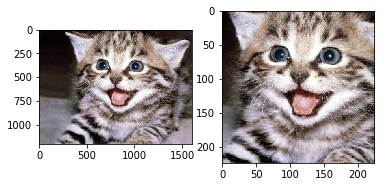

In [12]:
# Validate inference
from skimage.color import rgba2rgb
import skimage.io as io
import numpy as np
import os

def classify(net, url, contexts):
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(1, 2, 1)
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                 mean=mx.nd.array([0.485, 0.456, 0.406]),
                                 std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    data = mx.nd.SoftmaxActivation(net(image.as_in_context(contexts[0])))
    
    top = 5
    archive_synset = 'synset.txt'
    synset = archive_synset
    labels = [line.strip() for line in open(synset).readlines()]
    dim = len(data.shape)
    if dim > 2:
        data = mx.nd.array(
            np.squeeze(data.asnumpy(), axis=tuple(range(dim)[2:])))
    sorted_prob = mx.nd.argsort(data[0], is_ascend=False)
    top_prob = map(lambda x: int(x.asscalar()), sorted_prob[0:top])
    print([{'probability': float(data[0, i].asscalar()), 'class': labels[i]}
            for i in top_prob])
    #print('Probabilities are: '+str(out[0].asnumpy()))
    #result = np.argmax(out.asnumpy())
    #outstring = ['Not hotdog!', 'Hotdog!']
    #print(outstring[result])

# Replace kitten.jpg with any local image file or url
classify(squeezenet, 'kitten.jpg', contexts)

## Model Quest: the signature

Welcome to your next mission where we take a look at inputs and outputs of the model and provide this information in a json file for MMS to use. This file, `signature.json`, is the next artifact in your quest.

In many cases with image recognition models from the model zoo, they're based around ImageNet, use the same size of inputs, and use the same number of outputs.

Thankfully a template for this file is available for you to use. Inspect the block below, and we'll discuss each part, starting with the `inputs`.

In [14]:
signature = {
  "inputs": [
    {
      "data_name": "data",
      "data_shape": [0, 3, 224, 224]
    }
  ],
  "input_type": "image/jpeg",
  "outputs": [
    {
      "data_name": "softmax",
      "data_shape": [0, 1000]
    }
  ],
  "output_type": "application/json"
}


### Inputs

* `"data_name": "data",` - the name of the first input layer

If you open up the `artifact-model-symbol.json` file you can see that "data" is listed at the top. Let's just do that now by looking at the first seven lines.


In [13]:
# Views the top 7 lines of the symbol artifact
!head -7 squeezenet_model/artifact-model-symbol.json

{
  "nodes": [
    {
      "op": "null", 
      "name": "data", 
      "inputs": []
    }, 


If you were looking at a converted ONNX model, for example, the `name` payload will be `input_0` instead of `data`. But we're not, and in this case our `name` is `data`! So that's what goes into the signature in the `data_name` field.

* `"data_shape": [0, 3, 224, 224]` - the shape of the images that model was trained on in NCHW format. Translation: the model's input is images that are 224x224 pixels in size.

For your purposes you may not know (or care at this point) what NCHW is. The last two entries in that shape array are fairly important though: height and width, which in this case is 224x224. Now, it would be great if we could inspect the symbol file for this info, but it's not there. For this, you need to do a bit of research. However, look no further because this is the shape for many vision models that were trained on ImageNet using AlexNet as a general guide, and SqueezeNet is no exception.

* `"input_type": "image/jpeg",` - the model's input is images that are in the `jpeg` format. 

Not bmp, not png, not tiff. So you will need to convert that animated gif file before trying to see if squeezenet can detect grumpycat or not.

### Outputs

* `"data_name": "softmax",` - this is the output layer that returns the array of predictions; sometimes referred to as a tensor.

You won't need to modify this for any of the examples in your quest.

* `"data_shape": [0, 1000]` - SqueezeNet outputs 1,000 predictions, so for each inference request, you get one row, with a thousand results in it.

So, we're pretty much handing you this artifact, but forcing you to read a bunch of stuff in hopes that you understand what you're getting. Save it to the directory with your other artifacts using the next code block.

In [18]:
from json import dumps
print(dumps(signature))
%store dumps(signature) > squeezenet_model/signature.json

{"inputs": [{"data_name": "data", "data_shape": [0, 3, 224, 224]}], "input_type": "image/jpeg", "outputs": [{"data_name": "softmax", "data_shape": [0, 1000]}], "output_type": "application/json"}
Writing 'dumps(signature)' (str) to file 'squeezenet_model/signature.json'.


## Model Quest: the model service

The model service is what handles pre and post-processing for every inference request. 

### Pre-processing

This means every incoming image that is going to run on the model gets resized and reformatted so that the model has the best chance of detecting accurately. Upload a giant image, it gets resized to 224x224. Upload a small one, it gets upsampled to 224x224. Upload a weird aspect ratio, it gets cropped.

### Post-processing

After the model returns its results you would have this really big array of 1,000 probabilities. Most of the time you just want to know the top result, or maybe the top 5 results. 

### Options
MMS provides a vision service does these things for you, and for image/vision models it runs by default, requiring no actual artifact from you! So we're going to hold off on this one for now and cover custom services later. Hooray! A free artifact!

## Model Quest: the labels

Labels are an optional component that make using MMS a lot more user friendly. When you get your 1,000 different probabilities they are just IDs. Something like: `"class": "n02124075", "probability": 0.9408261179924011` is telling you some random ID is 94% likely in the image you submitted to the model. Providing labels turns that into `"class": "n02124075 Egyptian cat", "probability": 0.9408261179924011` which is much more interesting.

Let's grab the standard labels file for all of these ImageNet/AlexNet based models, `synset.txt`. When this file, specifically by name, is detected, it gets used by the model service in post-processing to massage the results that are returned.

We'll download it, and then check on all of our artifacts.

In [19]:
!curl -o squeezenet_model/synset.txt https://raw.githubusercontent.com/tornadomeet/ResNet/master/predict/synset.txt
%ls squeezenet_model

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31675  100 31675    0     0   160k      0 --:--:-- --:--:-- --:--:--  160k
artifact-model-0000.params  signature.json
artifact-model-symbol.json  synset.txt


## Artifacts Quest: forging the one model

Now that you have all of the artifacts needed for serving a SqueezeNet model, let's use `mxnet-model-export` to forge these into one `.model` archive that MMS can serve.

First, let's take a look at the `--help` output.

In [20]:
!mxnet-model-export --help

/Users/markhama/Development/mxnet3.6/lib/python3.6/site-packages/mxnet_model_server-0.2-py3.6.egg/mms/export_model.py:18: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
usage: mxnet-model-export [-h] --model-name MODEL_NAME --model-path MODEL_PATH
                          [--service-file-path SERVICE_FILE_PATH]

MXNet Model Export

optional arguments:
  -h, --help            show this help message and exit
  --model-name MODEL_NAME
                        Exported model name. Exported file will be named as
                        model-name.model and saved in current working
                        directory.
  --model-path MODEL_PATH
                        Path to the folder containing model related files.
                        Signature file is required.
  --service-file-path SERVICE_FILE_PATH
                        Service file path to handle custom MMS inference
                        l

### Using mxnet-model-export
We're only going to use `--model-name` and `--model-path`. The model name can be whatever we want to call it, but the model path needs to be where the artifacts are being held. It's going to create the model in the current working directory, so we'll also move the model when we're done and view it in the models folder.

In [23]:
!mxnet-model-export --model-name model-quest --model-path squeezenet_model
%mkdir models
%mv model-quest.model models/
%ls models

/Users/markhama/Development/mxnet3.6/lib/python3.6/site-packages/mxnet_model_server-0.2-py3.6.egg/mms/export_model.py:18: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
model-quest.model


### Using mxnet-model-server

Now we are ready to launch MMS. We could do it from here, but then it will take over the notebook and we won't be able to run any further commands. 

1. **Open your terminal** and browse to this tutorial's directory. 
2. Then **run MMS** with the following command:

```
mxnet-model-server --models hodor=models/hodor.model
```

We can test images by using `curl` to upload them to the `predict` endpoint on MMS's REST API. A kitten pic is already in this folder, so we can just use that!

### DEBUG
This result is because the image isn't getting normalized in preprocessing with the default vision service. Adding the adjustments will at least detect a cat instead of a saltshaker.

In [17]:
!curl -X POST http://127.0.0.1:8080/hodor/predict -F "data=@kitten.jpg"

{
  "prediction": [
    [
      {
        "class": "n04131690 saltshaker, salt shaker", 
        "probability": 417.7922668457031
      }, 
      {
        "class": "n03476684 hair slide", 
        "probability": 364.9322814941406
      }, 
      {
        "class": "n02094433 Yorkshire terrier", 
        "probability": 364.84027099609375
      }, 
      {
        "class": "n04209239 shower curtain", 
        "probability": 362.7345275878906
      }, 
      {
        "class": "n09229709 bubble", 
        "probability": 353.0511779785156
      }
    ]
  ]
}


## Post-Quest Lunch at the Model Zoo

Now that you've done all that questing and forging and exporting and serving, I bet you're famished. Let's order the Zoo's special: a hotdog. But at this Zoo they sometimes run out, and will give you a meal that's not a hotdog. We haven't built an AI that can taste yet, or a computer with a mouth that's used for chewing for that matter, but we can have something that can tell the difference between images. Let's build a new model that can tell the difference!

### Applying a fine-tuned model
We can use the same model that we've been playing with already, SqueezeNet, but load it up with a custom version that's been ["fine-tuned" for hot dog detection](http://gluon.mxnet.io/chapter08_computer-vision/fine-tuning.html). This is the `.params` file we're downloading in the next block.

We'll call this model `deep_dog_net`, and pass in two different arguments than we used before. Since we're going to load some custom trained parameters we're not going to use the `pretrained` argument. We're using `prefix='deep_dog_` because the parameters were trained to have this prefix. We will also limit the number of classes to two with `classes=2` because this custom model's output layer was modified to only output two results: it's a "hotdog" or it's "not a hotdog".

In the next block we'll download the pre-trained not-hotdog params, move it to an artifacts folder, and fire up the network.

In [25]:
from mxnet.test_utils import download
download('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/deep-dog-5a342a6f.params',
         overwrite=True)
%mkdir nothotdog
%mv deep-dog-5a342a6f.params nothotdog/
deep_dog_net = models.squeezenet1_1(prefix='deep_dog_', classes=2)

Now the rest of the code should look familiar. We'll do the same last three steps as before, but instead of initializing the network we'll just load the parameters that we just downloaded.
1. load params (new!)
1. hybridize
1. run once
1. export

In [132]:
# Step 1: load pre-trained params
deep_dog_net.load_params('deep-dog-5a342a6f.params', contexts)
# Step 2: hybridize
deep_dog_net.hybridize()
# Step 3: run once
F = mx.nd.random.uniform(shape=(1,3,224,224), ctx=contexts[0])
deep_dog_net(F)
deep_dog_net.export('nothotdog/nothotdog')

### Crafting a new signature
Here's where things get a little tricky! We need to tweak the signature a bit since now our output layer is limit to 2 results. Here's the signature we used before, and it's output has a `data_shape` of `[0, 1000]`. This needs to change to `[0, 2]`. Update it in the next block.

In [133]:
signature = {
  "inputs": [
    {
      "data_name": "data",
      "data_shape": [0, 3, 224, 224]
    }
  ],
  "input_type": "image/jpeg",
  "outputs": [
    {
      "data_name": "softmax",
      "data_shape": [0, 2]
    }
  ],
  "output_type": "application/json"
}

Now you're ready to save this new signature file in your artifacts directory for this model.

In [134]:
print(dumps(signature))
%store dumps(signature) > nothotdog/signature.json
%ls nothotdog

{"inputs": [{"data_name": "data", "data_shape": [0, 3, 224, 224]}], "input_type": "image/jpeg", "outputs": [{"data_name": "softmax", "data_shape": [0, 2]}], "output_type": "application/json"}
Writing 'dumps(signature)' (str) to file 'nothotdog/signature.json'.
__pycache__/           nothotdog-0000.params  signature.json
hotdog_service.py      nothotdog-symbol.json


### Crafting a custom service

Now that you have a fine-tuned model, you must be sure that the inputs (various images) are being pre-processed in a way that aligns with how the model was trained. In this case we must be sure to normalize the image color, and when we do so, we'll get much better results.

Additionally, we want to change the output since we now only have two classes, instead of 1,000 classes like we had before. In fact, we're going to have it output something silly: "hotdog", or "not hotdog".

To load the templated service file: 
1. create a new cell below
2. paste the following code: `%load hotdog_service.py`
3. then run the cell

Make your edits to the `MXNetVisionService` class.
Then replace the first line with the following, and run the cell to save the file:
```
%%writefile nothotdog/hotdog_service.py
```

In [126]:
%%writefile nothotdog/hotdog_service.py
# Copyright 2017 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License").
# You may not use this file except in compliance with the License.
# A copy of the License is located at
#     http://www.apache.org/licenses/LICENSE-2.0
# or in the "license" file accompanying this file. This file is distributed
# on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
# express or implied. See the License for the specific language governing
# permissions and limitations under the License.

"""`MXNetVisionService` defines a MXNet base vision service
"""

from mms.model_service.mxnet_model_service import MXNetBaseService
from mms.utils.mxnet import image, ndarray
import numpy as np
import mxnet as mx

class MXNetVisionService(MXNetBaseService):
    """MXNetVisionService defines a fundamental service for image classification task.
    In preprocess, input image buffer is read to NDArray and resized respect to input
    shape in signature.
    In post process, top-5 labels are returned.
    """
    def _preprocess(self, data):
        img_list = []
        for idx, img in enumerate(data):
            input_shape = self.signature['inputs'][idx]['data_shape']
            # We are assuming input shape is NCHW
            [h, w] = input_shape[2:]
            img_arr = image.read(img)
            # Transformations should match training inputs/transformations
            img_arr = mx.image.resize_short(img_arr, 256)
            img_arr, _ = mx.image.center_crop(img_arr, (w, h))
            # This normalization step is important to improve inference results
            img_arr = mx.image.color_normalize(img_arr.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
            #img_arr = image.resize(img_arr, w, h)
            img_arr = image.transform_shape(img_arr)

            img_list.append(img_arr)
        return img_list

    def _postprocess(self, data):
        #assert hasattr(self, 'labels'), \
        #    "Can't find labels attribute. Did you put synset.txt file into " \
        #    "model archive or manually load class label file in __init__?"
        for d in data:
            #print('Probabilities are: '+str(out[0].asnumpy()))
            result = np.argmax(d.asnumpy())
            outstring = ['Not hotdog! '+str(d.asnumpy()), 'Hotdog! '+str(d.asnumpy())]
            #print(outstring[result])
        return outstring[result]
        #return [ndarray.top_probability(d, self.labels, top=5) for d in data]


Overwriting nothotdog/hotdog_service.py


Now we're ready to export it, and this time we're using a custom service, so we need to add `--service-file-path` and the full path to the python file we just saved in the artifacts folder.

In [135]:
!mxnet-model-export --model-name nothotdog --model-path nothotdog --service-file-path nothotdog/hotdog_service.py

/Users/markhama/Development/mxnet3.6/lib/python3.6/site-packages/mxnet_model_server-0.2-py3.6.egg/mms/export_model.py:18: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [138]:
%mkdir models
%mv nothotdog.model models/
%ls models

mkdir: models: File exists
mv: nothotdog.model: No such file or directory
hodor/            nothotdog.model   nothotdog1.model
hodor.model       nothotdog1/


Now we are ready to launch MMS. We could do it from here, but then it will take over the notebook and we won't be able to run any further commands. Open your terminal and browse to this tutorial's directory. Then run MMS with the following command:

```
mxnet-model-server --models nhd=models/nothotdog.model
```

You should see some output that the server has started and available on a local port:
```
[INFO 2018-02-01 12:55:46,242 PID:99553 /Library/Python/2.7/site-packages/mxnet_model_server-0.2-py2.7.egg/mms/mxnet_model_server.py:start_model_serving:109] Service description endpoint: 127.0.0.1:8080/api-description
[INFO 2018-02-01 12:55:46,242 PID:99553 /Library/Python/2.7/site-packages/mxnet_model_server-0.2-py2.7.egg/mms/mxnet_model_server.py:start_model_serving:110] Service health endpoint: 127.0.0.1:8080/ping
[INFO 2018-02-01 12:55:46,248 PID:99553 /Users/markhama/Library/Python/2.7/lib/python/site-packages/werkzeug/_internal.py:_log:88]  * Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
```

### Ready to eat?

The first course comes out. Doesn't look quite right. Let's see what our model says!

![mushrooms](tan_ones.jpg)

In [141]:
!curl -X POST http://127.0.0.1:8080/nhd/predict -F "data=@tan-ones.jpg"

{
  "prediction": "Not hotdog! [[  8.42008781e+00   5.40525652e-04]]"
}


"Alright chef, knock it off," you say. "I want a real hot dog!".
So he gives you this:
![hot dog](real_hotdog.jpg)

Looks better! Let's see what the model says.

In [140]:
!curl -X POST http://127.0.0.1:8080/nhd/predict -F "data=@real_hotdog.jpg"

{
  "prediction": "Hotdog! [[ 1.41119111  5.72047758]]"
}


Hooray! It looks like a hotdog. There's no telling what the meat is from, but who cares? It looks delicious and our model can't be wrong. Actually, it can, but you're hungry so you eat it anyway.